https://towardsdatascience.com/time-series-forecasting-968192b3781a

In [16]:
!wget -q "https://raw.githubusercontent.com/Kanbc/ar-model-python/master/data/daily-minimum-temperatures.csv"

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
import warnings
warnings.filterwarnings('ignore')

1 Load and Explore Time Series Data


Load a Time Series Data

In [19]:
# load dataset
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True )
print(type(series))

<class 'pandas.core.frame.DataFrame'>


In [20]:
series[:10]

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


In [27]:
series.index.min()

Timestamp('1981-01-01 00:00:00')

In [25]:
series.index.max()

Timestamp('1990-12-31 00:00:00')

In [29]:
series['1981-01'].head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [30]:
series.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


2 Feature Engineering

Tworzenie funkcji lagów

‎Jest to klasyczne podejście do przekształcania problemów z prognozowaniem szeregów czasowych w nadzorowane problemy z uczeniem się. W tym podejściu wartość w czasie (t) jest używany do przewidywania wartości w następnym czasie (t + 1).‎

‎
W pandas, funkcje opóźnienia mogą być tworzone przez funkcję shift(), która tworzy kolumnę t przez przesunięcie zestawu danych o 1, a oryginalna seria bez zmiany reprezentuje t+1.‎



In [32]:
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True)
var = pd.DataFrame(series.values)
dataframe = pd.concat([var.shift(1), var], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head(5)

,t,t+1
0,NaN,20.7
1,20.7,17.9
2,17.9,18.8
3,18.8,14.6
4,14.6,15.8


3 Data Visualization

Line plot

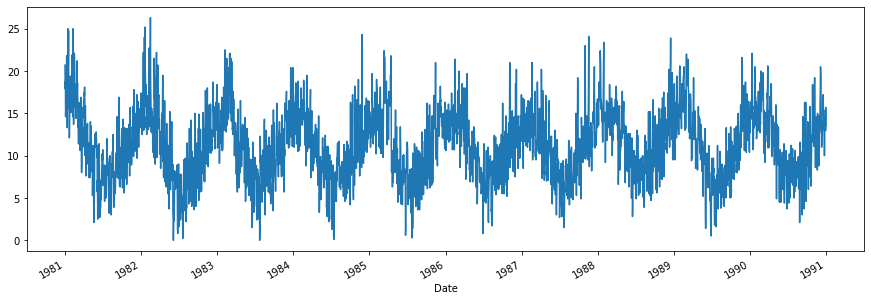

In [38]:
# create a line plot
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot(figsize=(15,5))
pyplot.show()

Często pomocne jest porównanie wykresów liniowych dla tego samego przedziału z różnymi przedziałami czasowymi, na przykład z dnia na dzień, z miesiąca na miesiąc i z roku na rok. W poniższym przykładzie porównaliśmy minimalną dzienną temperaturę przez 10 lat przez 365 dni. Pogrupujmy dane według lat i utwórzmy wykres liniowy dla każdego roku.

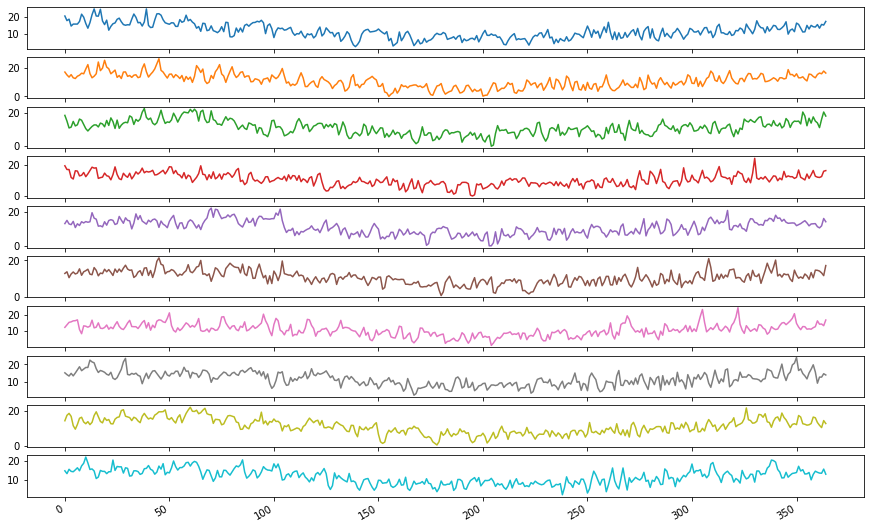

In [42]:
# create yearly (stacked) line plots
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

groups = series.groupby(pd.Grouper(freq='A'))

years = pd.DataFrame()

for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, legend=False,figsize=(15, 10))
pyplot.show()

Histogram and Density Plot

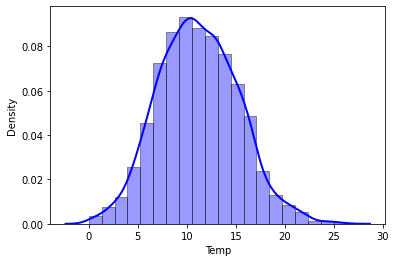

In [43]:
#Create histogram with density plot
import seaborn as sns
sns.distplot(series, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

Box and Whisker Plot


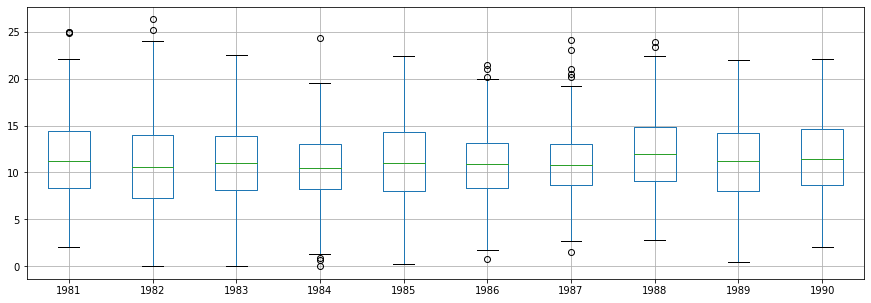

In [44]:
# create a boxplot of yearly data
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,  parse_dates=True, squeeze=True)

groups = series.groupby(pd.Grouper(freq='A'))

years = pd.DataFrame()

for name, group in groups:
    years[name.year] = group.values

years.boxplot(figsize=(15,5))
pyplot.show()

Możemy użyć tych wykresów obok siebie na poziomie rocznym, aby porównać każdy przedział czasowy w szeregu czasowym.

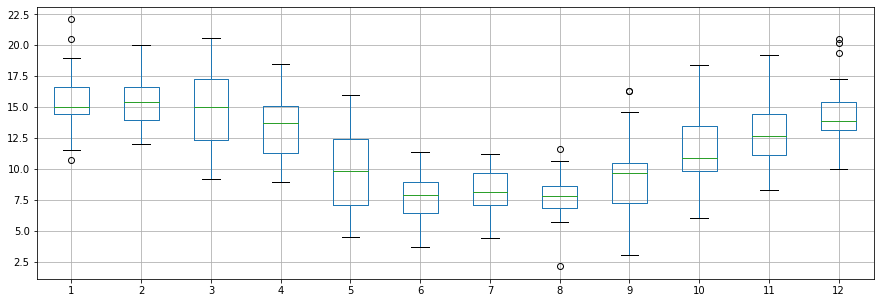

In [45]:
# create a monthly boxplots
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

single_year = series['1990']

groups = single_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)

months.boxplot(figsize=(15,5))
pyplot.show()


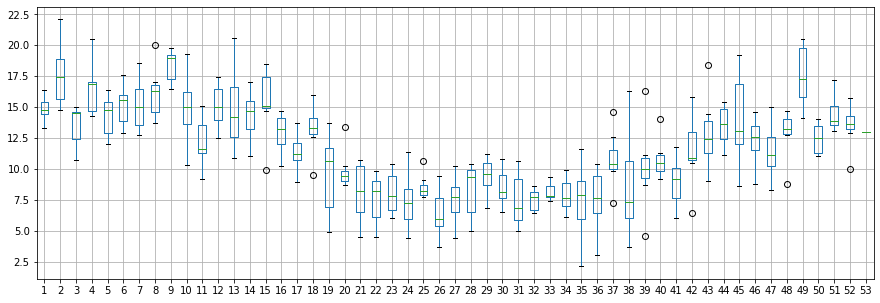

In [59]:
# create a week boxplots
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

single_year = series['1990']

groups = single_year.groupby(pd.Grouper(freq='1W'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months.columns = range(1,len(groups)+1)

months.boxplot(figsize=(15,5))
pyplot.show()


Jak to zostało zrobione

In [66]:
single_year

Date
1990-01-01    14.8
1990-01-02    13.3
1990-01-03    15.6
1990-01-04    14.5
1990-01-05    14.3
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 365, dtype: float64

In [74]:
groups = single_year.groupby(pd.Grouper(freq='1W'))
groups

In [76]:
for x in groups:
  print(x)

(Timestamp('1990-01-07 00:00:00', freq='W-SUN'), Date
1990-01-01    14.8
1990-01-02    13.3
1990-01-03    15.6
1990-01-04    14.5
1990-01-05    14.3
1990-01-06    15.3
1990-01-07    16.4
Name: Temp, dtype: float64)
(Timestamp('1990-01-14 00:00:00', freq='W-SUN'), Date
1990-01-08    14.8
1990-01-09    17.4
1990-01-10    18.8
1990-01-11    22.1
1990-01-12    19.0
1990-01-13    15.5
1990-01-14    15.8
Name: Temp, dtype: float64)
(Timestamp('1990-01-21 00:00:00', freq='W-SUN'), Date
1990-01-15    14.7
1990-01-16    10.7
1990-01-17    11.5
1990-01-18    15.0
1990-01-19    14.5
1990-01-20    14.5
1990-01-21    13.3
Name: Temp, dtype: float64)
(Timestamp('1990-01-28 00:00:00', freq='W-SUN'), Date
1990-01-22    14.3
1990-01-23    14.3
1990-01-24    20.5
1990-01-25    15.0
1990-01-26    17.1
1990-01-27    16.9
1990-01-28    16.9
Name: Temp, dtype: float64)
(Timestamp('1990-02-04 00:00:00', freq='W-SUN'), Date
1990-01-29    13.6
1990-01-30    16.4
1990-01-31    16.1
1990-02-01    12.0
1990-02-02

In [75]:
for x in groups:
  print(x[1].values)

[14.8 13.3 15.6 14.5 14.3 15.3 16.4]
[14.8 17.4 18.8 22.1 19.  15.5 15.8]
[14.7 10.7 11.5 15.  14.5 14.5 13.3]
[14.3 14.3 20.5 15.  17.1 16.9 16.9]
[13.6 16.4 16.1 12.  12.2 14.8 14.8]
[14.4 12.9 13.4 15.9 16.1 17.6 15.6]
[15.  13.  14.1 17.3 15.7 18.6 12.7]
[14.  13.7 16.3 20.  17.  15.2 16.5]
[16.5 17.3 19.1 19.3 17.3 19.  19.8]
[19.3 17.2 14.2 10.3 13.  15.3 15. ]
[12.1  9.2 11.  15.  11.6 11.6 15.1]
[15.  13.6 12.5 14.3 16.  17.4 16.9]
[18.  20.6 14.2 10.9 11.9 13.3 15.3]
[14.7 11.  12.2 14.2 17.  15.8 15.2]
[15.1 14.7 18.5 16.4 18.4 15.1  9.9]
[10.2 12.6 13.2 11.5 13.8 14.5 14.7]
[11.2 12.7 13.7 11.5 10.4  8.9 11.1]
[ 9.5 13.  13.9 12.6 14.3 16.  13.3]
[ 7.   4.9  6.9 13.7 10.6 12.3 11.1]
[10.2  9.5  8.9 13.4  9.1  9.4  8.7]
[ 5.8  4.5  7.2 10.  10.5 10.7  8.2]
[6.1 4.5 6.1 9.8 9.7 8.2 8.4]
[ 8.5 10.4  6.8  6.   6.6  7.8 10.3]
[ 7.2  7.4 11.4  5.4  4.4  6.4  9.3]
[ 7.7  8.1  8.3  9.1  7.7 10.6  8.2]
[7.9 5.2 5.9 3.7 5.6 9.4 7.4]
[ 7.3  7.7  7.7  9.3  4.4  5.7 10.2]
[10.2  9.3  5.4

In [60]:
pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,14.8,14.8,14.7,14.3,13.6,14.4,15.0,14.0,16.5,19.3,12.1,15.0,18.0,14.7,15.1,10.2,11.2,9.5,7.0,10.2,5.8,6.1,8.5,7.2,7.7,7.9,7.3,10.2,11.2,9.8,6.0,7.8,7.8,9.7,2.1,8.6,10.5,3.7,10.6,11.3,6.0,15.8,9.0,13.6,12.5,12.6,9.9,12.9,16.2,11.0,13.9,10.0,13.0
1,13.3,17.4,10.7,14.3,16.4,12.9,13.0,13.7,17.3,17.2,9.2,13.6,20.6,11.0,14.7,12.6,12.7,13.0,4.9,9.5,4.5,4.5,10.4,7.4,8.1,5.2,7.7,9.3,9.1,10.8,5.0,7.7,9.3,9.9,5.9,7.6,14.6,7.3,16.3,10.5,9.8,14.6,10.9,14.9,18.3,13.8,8.3,8.8,17.3,11.1,17.2,12.9,NaN
2,15.6,18.8,11.5,20.5,16.1,13.4,14.1,16.3,19.1,14.2,11.0,12.5,14.2,12.2,18.5,13.2,13.7,13.9,6.9,8.9,7.2,6.1,6.8,11.4,8.3,5.9,7.7,5.4,11.2,9.2,6.8,8.6,8.4,6.1,11.6,10.4,12.6,11.6,9.8,9.9,9.2,10.5,12.4,14.8,19.2,14.6,15.0,14.7,20.5,14.0,14.7,14.6,NaN
3,14.5,22.1,15.0,15.0,12.0,15.9,17.3,20.0,19.3,10.3,15.0,14.3,10.9,14.2,16.4,11.5,11.5,12.6,13.7,13.4,10.0,9.8,6.0,5.4,9.1,3.7,9.3,5.0,6.8,6.5,9.8,6.5,7.8,6.6,8.6,10.3,9.8,16.3,4.6,11.0,11.8,11.3,11.6,15.4,15.4,13.2,12.2,14.7,20.2,11.4,15.4,14.0,NaN
4,14.3,19.0,14.5,17.1,12.2,16.1,15.7,17.0,17.3,13.0,11.6,16.0,11.9,17.0,18.4,13.8,10.4,14.3,10.6,9.1,10.5,9.7,6.6,4.4,7.7,5.6,4.4,7.6,8.3,8.1,5.7,6.9,7.4,7.6,7.9,7.5,7.2,9.6,11.1,14.0,10.3,10.9,13.3,11.8,13.1,12.3,10.5,12.7,19.4,12.5,13.1,13.6,NaN
5,15.3,15.5,14.5,16.9,14.8,17.6,18.6,15.2,19.0,15.3,11.6,17.4,13.3,15.8,15.1,14.5,8.9,16.0,12.3,9.4,10.7,8.2,7.8,6.4,10.6,9.4,5.7,9.6,9.7,7.3,8.6,6.4,7.7,7.4,6.0,3.0,10.1,6.8,8.7,9.2,7.5,6.4,14.4,13.0,11.5,8.8,11.1,13.3,15.5,13.4,13.2,13.5,NaN
6,16.4,15.8,13.3,16.9,14.8,15.6,12.7,16.5,19.8,15.0,15.1,16.9,15.3,15.2,9.9,14.7,11.1,13.3,11.1,8.7,8.2,8.4,10.3,9.3,8.2,7.4,10.2,10.4,9.6,7.9,10.6,8.5,8.9,8.0,9.5,5.3,10.4,5.2,10.0,9.8,7.7,10.9,18.4,11.1,8.6,10.7,13.0,13.2,14.1,13.6,13.9,15.7,NaN


liste z nazwami kolumna (każda to "0") zastą listą od 1 do ilość zgupowanych elementów + 1 (liczy od 0)

In [ ]:
months.columns = range(1,len(groups)+1)

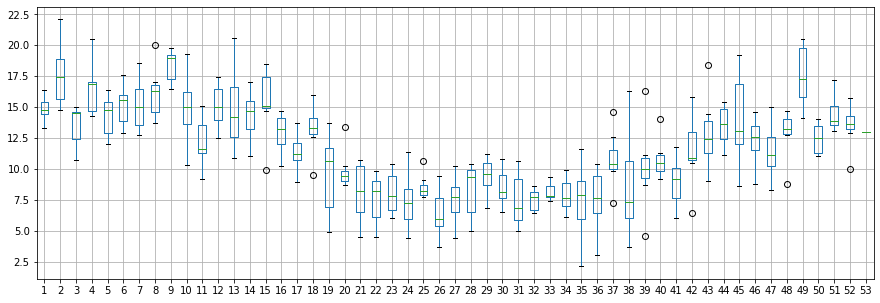

In [78]:
months.boxplot(figsize=(15,5))
pyplot.show()

Heat map

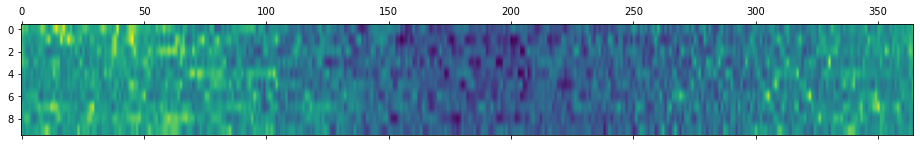

In [79]:
# create a heat map of yearly data
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()

for name, group in groups:
  years[name.year] = group.values  # wyciągnij sam rok z nazwy (która jest dt. )

years = years.T

pyplot.matshow(years, interpolation=None, aspect='auto')
pyplot.show()

In [82]:
series

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 3650, dtype: float64

In [83]:
groups = series.groupby(pd.Grouper(freq='A'))
groups

In [89]:
for i in groups:
  print(i)

(Timestamp('1981-12-31 00:00:00', freq='A-DEC'), Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1981-12-27    15.5
1981-12-28    13.3
1981-12-29    15.6
1981-12-30    15.2
1981-12-31    17.4
Name: Temp, Length: 365, dtype: float64)
(Timestamp('1982-12-31 00:00:00', freq='A-DEC'), Date
1982-01-01    17.0
1982-01-02    15.0
1982-01-03    13.5
1982-01-04    15.2
1982-01-05    13.0
              ... 
1982-12-27    15.3
1982-12-28    16.3
1982-12-29    15.8
1982-12-30    17.7
1982-12-31    16.3
Name: Temp, Length: 365, dtype: float64)
(Timestamp('1983-12-31 00:00:00', freq='A-DEC'), Date
1983-01-01    18.4
1983-01-02    15.0
1983-01-03    10.9
1983-01-04    11.4
1983-01-05    14.8
              ... 
1983-12-27    13.9
1983-12-28    11.1
1983-12-29    16.1
1983-12-30    20.4
1983-12-31    18.0
Name: Temp, Length: 365, dtype: float64)
(Timestamp('1984-12-31 00:00:00', freq='A-DEC'), Date
1984-01-01    19.5
1984-01-02    1

In [84]:
years = pd.DataFrame()

In [85]:
for name, group in groups:
  print("name",name,"-","group",group)

name 1981-12-31 00:00:00 - group Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1981-12-27    15.5
1981-12-28    13.3
1981-12-29    15.6
1981-12-30    15.2
1981-12-31    17.4
Name: Temp, Length: 365, dtype: float64
name 1982-12-31 00:00:00 - group Date
1982-01-01    17.0
1982-01-02    15.0
1982-01-03    13.5
1982-01-04    15.2
1982-01-05    13.0
              ... 
1982-12-27    15.3
1982-12-28    16.3
1982-12-29    15.8
1982-12-30    17.7
1982-12-31    16.3
Name: Temp, Length: 365, dtype: float64
name 1983-12-31 00:00:00 - group Date
1983-01-01    18.4
1983-01-02    15.0
1983-01-03    10.9
1983-01-04    11.4
1983-01-05    14.8
              ... 
1983-12-27    13.9
1983-12-28    11.1
1983-12-29    16.1
1983-12-30    20.4
1983-12-31    18.0
Name: Temp, Length: 365, dtype: float64
name 1984-12-31 00:00:00 - group Date
1984-01-01    19.5
1984-01-02    17.1
1984-01-03    17.1
1984-01-04    12.0
1984-01-05    11.0
      

In [86]:
for name, group in groups:
  years[name.year] = group.values
years

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
0,20.7,17.0,18.4,19.5,13.3,12.9,12.3,15.3,14.3,14.8
1,17.9,15.0,15.0,17.1,15.2,13.8,13.8,14.3,17.4,13.3
2,18.8,13.5,10.9,17.1,13.1,10.6,15.3,13.5,18.5,15.6
3,14.6,15.2,11.4,12.0,12.7,12.6,15.6,15.0,16.8,14.5
4,15.8,13.0,14.8,11.0,14.6,13.7,16.2,13.6,11.5,14.3
...,...,...,...,...,...,...,...,...,...,...
360,15.5,15.3,13.9,12.2,11.5,14.6,16.2,9.5,13.3,14.0
361,13.3,16.3,11.1,12.0,10.8,14.2,14.2,12.9,11.7,13.6
362,15.6,15.8,16.1,12.6,12.0,13.2,14.3,12.9,10.4,13.5
363,15.2,17.7,20.4,16.0,16.3,11.7,13.3,14.8,14.4,15.7


In [87]:
years = years.T
years

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
1981,20.7,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7,20.6,24.8,17.7,15.5,18.2,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9,16.6,16.8,14.6,17.1,25.0,...,10.1,15.8,13.6,11.9,9.9,12.6,17.8,15.0,13.6,13.4,10.5,14.2,11.5,13.0,15.0,14.7,12.6,12.5,13.5,14.8,17.2,9.7,12.1,12.8,11.2,16.4,15.6,13.3,11.0,11.1,15.0,12.8,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4
1982,17.0,15.0,13.5,15.2,13.0,12.5,14.1,14.8,16.2,15.8,19.1,22.2,15.9,13.0,14.1,15.8,24.0,18.0,19.7,25.2,20.5,19.3,15.8,17.0,18.4,13.3,14.6,12.5,17.0,17.1,14.0,14.6,13.3,14.8,15.1,13.1,13.6,19.5,22.7,17.2,...,10.3,13.7,16.0,15.8,12.1,12.5,12.2,13.7,16.1,15.5,10.3,10.5,11.0,11.9,13.0,12.2,10.6,13.0,13.0,12.2,12.6,18.7,15.2,15.3,13.9,15.8,13.0,13.0,13.7,12.0,10.8,15.6,15.3,13.9,13.0,15.3,16.3,15.8,17.7,16.3
1983,18.4,15.0,10.9,11.4,14.8,12.1,12.8,16.2,15.5,13.0,10.5,9.1,10.5,11.8,12.7,12.7,11.5,13.8,13.3,11.6,15.4,12.4,16.9,14.7,10.6,15.6,10.7,12.6,13.8,14.3,14.0,18.1,17.3,13.0,16.0,14.9,16.2,20.3,22.5,17.2,...,16.2,15.0,14.5,15.9,14.9,14.2,15.8,17.2,17.6,12.1,11.4,13.0,13.2,12.0,15.3,12.7,12.1,13.8,10.9,12.0,16.5,15.0,11.2,13.9,15.0,14.8,15.0,13.3,20.4,18.0,12.2,16.7,13.8,17.5,15.0,13.9,11.1,16.1,20.4,18.0
1984,19.5,17.1,17.1,12.0,11.0,16.3,16.1,13.0,13.4,15.2,12.5,14.3,16.5,18.6,18.0,18.2,11.4,11.9,12.2,14.8,13.1,12.7,10.5,13.8,18.8,13.9,11.2,10.6,14.7,13.1,12.1,14.7,11.1,13.0,15.6,14.2,15.5,18.0,15.0,15.9,...,10.0,8.8,11.6,8.6,14.6,24.3,11.6,10.8,12.0,11.0,12.6,10.8,9.1,11.0,13.0,12.8,9.9,11.6,10.5,15.9,12.2,13.0,12.5,12.5,11.4,12.1,16.8,12.1,11.3,10.4,14.2,11.4,13.7,16.5,12.8,12.2,12.0,12.6,16.0,16.4
1985,13.3,15.2,13.1,12.7,14.6,11.0,13.2,12.2,14.4,13.7,14.5,14.1,14.4,19.7,16.5,15.9,11.8,12.0,11.4,14.4,12.4,15.1,15.6,15.2,12.8,13.3,17.5,15.4,13.5,16.7,15.2,14.9,10.2,13.6,19.0,15.7,18.0,14.8,13.9,13.0,...,10.1,8.8,13.7,16.2,16.0,14.0,13.7,12.5,12.8,12.3,15.2,15.0,16.4,16.1,14.6,18.2,16.4,16.6,14.7,15.8,14.1,13.5,13.6,13.7,13.6,12.1,12.7,13.3,14.2,15.0,13.7,12.0,13.1,13.2,13.3,11.5,10.8,12.0,16.3,14.4
1986,12.9,13.8,10.6,12.6,13.7,12.6,13.1,15.4,11.9,13.8,14.4,15.2,12.5,12.2,16.1,14.6,11.6,13.1,12.8,15.2,13.8,15.0,13.5,11.8,15.3,13.5,15.3,13.8,15.8,17.4,15.3,14.6,14.8,10.7,11.6,13.6,14.4,11.8,15.8,16.0,...,8.1,11.5,12.8,9.1,14.6,11.6,11.2,12.6,7.5,11.0,14.5,18.5,15.4,13.1,16.3,20.2,11.5,12.4,10.9,12.7,12.2,12.4,9.8,8.5,14.7,12.0,10.3,11.0,10.2,12.6,11.6,9.7,13.4,10.5,14.7,14.6,14.2,13.2,11.7,17.2
1987,12.3,13.8,15.3,15.6,16.2,16.3,16.8,11.0,8.5,13.2,13.0,12.4,13.0,16.6,12.0,12.4,15.0,11.8,11.6,12.2,13.7,11.2,12.4,11.5,13.8,15.7,12.9,11.5,11.0,12.7,14.9,16.5,12.8,12.7,12.7,11.6,13.3,15.2,16.4,11.9,...,8.7,13.3,11.6,9.9,10.8,11.5,10.0,13.9,13.6,11.9,11.1,8.2,9.4,12.7,11.6,11.0,11.3,13.4,14.9,15.2,13.9,15.0,16.2,17.7,20.5,14.7,12.5,10.9,12.8,12.7,11.2,11.4,11.2,12.1,12.7,16.2,14.2,14.3,13.3,16.7
1988,15.3,14.3,13.5,15.0,13.6,15.2,17.0,18.7,16.5,17.4,18.3,18.3,22.4,21.4,20.9,17.6,15.5,16.6,16.2,15.6,14.5,14.0,15.6,12.3,11.6,12.6,14.9,17.3,21.4,23.4,14.4,14.1,15.0,14.5,15.1,13.9,13.4,9.2,12.5,15.1,...,13.0,12.9,14.3,13.7,12.1,11.9,11.8,11.4,10.3,11.7,12.0,17.4,16.8,16.2,13.0,12.5,12.4,16.1,20.2,14.3,11.0,14.4,15.7,19.7,20.7,23.9,16.6,17.5,14.9,13.6,11.9,15.2,17.3,19.8,15.8,9.5,12.9,12.9,14.8,14.1
1989,14.3,17.4,18.5,16.8,11.5,9.5,12.2,15.7,16.3,13.6,12.6,13.8,12.1,13.4,17.3,19.4,16.6,13.9,13.1,16.0,14.5,15.0,12.6,12.5,15.2,16.2,16.5,20.1,20.6,16.9,16.5,16.1,14.4,16.3,15.7,14.2,13.2,16.8,18.5,16.7,...,15.5,21.6,14.9,14.4,12.9,13.1,14.0,17.9,17.7,16.3,18.3,13.7,13.3,10.6,14.1,16.0,16.5,14.1,18.7,16.2,14.8,12.6,10.4,12.2,12.6,12.1,17.3,16.4,12.6,12.3,11.8,12.0,12.7,16.4,16.0,13.3,11.7,10.4,14.4,12.7
1990,14.8,13.3,15.6,14.5,14.3,15.3,16.4,14.8,17.4,18.8,22.1,19.0,1

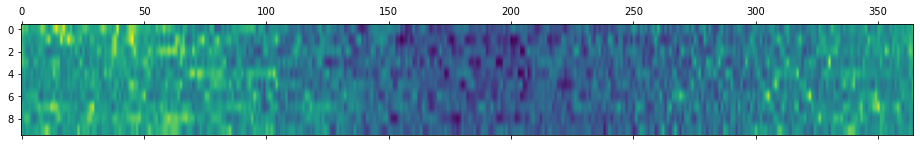

In [88]:
pyplot.matshow(years, interpolation=None, aspect='auto')
pyplot.show()